In [2]:
import pandas as pd
import os
import re
import csv

import seaborn as sns
import math
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import Levenshtein as L
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import itertools

# Preprocess on the data

As there is some encoding issue so we will need to do some preprocessing on our scrapped data

In [3]:
def clean_encoding(value):
    return value.replace('\u200b','').replace(
        '\ufeffCam ','Cam ').replace('%E2%80%8B','').replace("+",' ').replace('%EF%BB%BFCam','Cam')

In [4]:
data = pd.read_csv('data.csv')

In [5]:

def extract_name(value):
    pattern = re.compile('term=(.*)&sort=_desc')
    # encoding in url is different from product name
    return clean_encoding(pattern.search(value).group(1))

def match_price(value):
    with open('100.csv', mode='r') as infile:
        reader = csv.reader(infile)
        mydict = {clean_encoding(rows[1]):rows[2] for rows in reader}
    try:
        res = mydict[value]
    except:
        print(value)
        res = None
    return res

name_from_link = data['url'].apply(extract_name)
# refer_name is the original product names scrapped from bestproducts.com
data['refer_name'] = name_from_link
# refer_price is the original product prices scrapped from bestproducts.com
data['refer_price'] = data['refer_name'].apply(match_price)


In [6]:
data.to_csv('data_with_refer_name_price.csv')

So, we will be manually label whether the search results returned by iprice is correct

In [7]:
# Read in the manually labeled data
data = pd.read_csv('data_with_refer_name_price_label.csv', index_col = 0)

## Take a look at the data

In [8]:
data.head()

,ori_price,discount,name,brand,url,price,refer_name,refer_price,status
0,387.1,8.0,Jabra Elite Active 65t Alexa Enabled True Wire...,Lazada,https://iprice.sg/search/?term=Jabra+Elite+65t...,355.1,Jabra Elite 65t True Wireless Earbuds,166.48,0
1,NaN,NaN,Jabra Elite 65T True Wireless Earbuds,Lazada,https://iprice.sg/search/?term=Jabra+Elite+65t...,268,Jabra Elite 65t True Wireless Earbuds,166.48,1
2,NaN,NaN,Jabra Elite 65T True Wireless Earbuds,Lazada,https://iprice.sg/search/?term=Jabra+Elite+65t...,268,Jabra Elite 65t True Wireless Earbuds,166.48,1
3,268,11.0,Jabra Elite 65t True Wireless Earbuds,Lazada,https://iprice.sg/search/?term=Jabra+Elite+65t...,238,Jabra Elite 65t True Wireless Earbuds,166.48,1
4,NaN,NaN,Jabra Elite 65T True Wireless Earbuds,Lazada,https://iprice.sg/search/?term=Jabra+Elite+65t...,268,Jabra Elite 65t True Wireless Earbuds,166.48,1


In [9]:
data.shape

(1193, 9)

So we have 1193 records.

## Tidying data types

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1193 entries, 0 to 1192
Data columns (total 9 columns):
ori_price      678 non-null object
discount       678 non-null float64
name           1193 non-null object
brand          1193 non-null object
url            1193 non-null object
price          1193 non-null object
refer_name     1193 non-null object
refer_price    1193 non-null float64
status         1193 non-null int64
dtypes: float64(2), int64(1), object(6)
memory usage: 93.2+ KB


In [11]:
# Preprocessing data
data['price'] = data['price'].apply(lambda x:x.replace(',','')).astype('float')
data['ori_price'] = data['ori_price'].apply(lambda x:float(x.replace(',','')) if type(x)==str else 0)
data['refer_price'] = data['refer_price'].astype('float')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1193 entries, 0 to 1192
Data columns (total 9 columns):
ori_price      1193 non-null float64
discount       678 non-null float64
name           1193 non-null object
brand          1193 non-null object
url            1193 non-null object
price          1193 non-null float64
refer_name     1193 non-null object
refer_price    1193 non-null float64
status         1193 non-null int64
dtypes: float64(4), int64(1), object(4)
memory usage: 93.2+ KB


In [13]:
#Change to sgd
data['refer_price'] = data['refer_price']*1.37

Lets see how many of the original dataset cannot be found on iprice

In [14]:
ori_data = pd.read_csv('100.csv', index_col=0)

In [15]:
ori_data['prod_names'] = ori_data['prod_names'].apply(clean_encoding)

In [16]:
ori_data.shape

(100, 2)

So we have 100 electronics data to be scrapped from iprice.

In [17]:
len(data['refer_name'].unique())

63

However, there are only 63 records can be found on iprice

In [18]:
set(ori_data['prod_names']) - set(data['refer_name'].unique())

{'1MORE Piston Fit Wired Earbuds',
 'Airmega 400S Smart Air Purifier',
 'Amazon Echo Plus (2nd Gen) Smart Speaker',
 'Anker PowerCore Lite Battery Pack',
 'Apple TV 4K Streaming Console',
 'Audio-Technica AT-LP3WH Fully Automatic Turntable',
 'Blue Yeti Nano USB Microphone',
 'Bose Home Speaker 500 Smart Speaker with Amazon Alexa',
 'First Alert Onelink Safe & Sound Smoke   Carbon Monoxide Alarm',
 'Furbo Dog Camera with Treat Tossing Technology',
 'Google Home Hub Smart Display',
 'HP Omen Gaming Laptop (17-inch)',
 'Insta360 ONE 360-Degree Camera',
 'JBL Link View Smart Speaker',
 'LG Watch W7 Hybrid Smartwatch',
 'Master & Dynamic MW07 Completely Wireless Earbuds',
 'Microsoft Surface Go Windows 10 Tablet',
 'Netgear Orbi Mesh Wi-Fi System with Amazon Alexa',
 'OnePlus Type-C Bullets USB-C Earbuds',
 'Optoma UHD50 4K Home Theater Projector',
 'Pad & Quill Wooden Rollerball Pen',
 'Philips Somneo Sleep and Wake-up Light',
 'Pioneer Rayz Plus Noise-Canceling Lightning Earbuds',
 'Plan

In [19]:
len(set(ori_data['prod_names']) - set(data['refer_name'].unique()))

37

And the above are the products that cannot be found on iprice

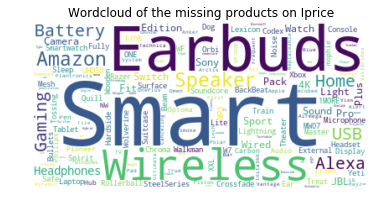

In [20]:
text = " ".join(name for name in set(ori_data['prod_names']) - set(data['refer_name'].unique()))
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud of the missing products on Iprice")
plt.show()

In [21]:
# remove smart as a lot of electronic devices like to add smart in their products title and hence, it might not
# be good representation of the missing products
missing = list(set(ori_data['prod_names']) - set(data['refer_name'].unique()))
missing = [x.lower().replace('smart','') for x in missing]

Lets plot the worldcloud again

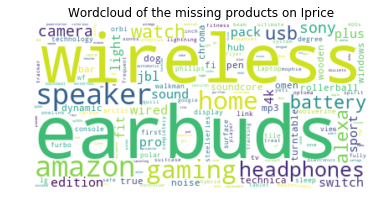

In [22]:
text = " ".join(name for name in missing)
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud of the missing products on Iprice")
plt.show()

## Cleaning data

In [23]:
data.brand.unique()

array(['Lazada', 'Qoo10', 'Shopee', 'Taobao', 'Amazon', 'LazMall',
       'Apple', 'Personal Digital', 'Zapals', 'Harvey Norman',
       'AliExpress', 'Light In The Box', 'Tomtop', 'Megafash',
       'Mini In The Box', 'YesStyle', 'Tidebuy', 'Nzgameshop',
       'Tech2cool'], dtype=object)

Note that LazMall and Lazada actually refer to same brand - Lazada, so we need to replace LazMall to Lazada.

In [24]:
data['brand'] = data['brand'].apply(lambda x: 'Lazada' if x =='LazMall' else x)
data['discount'].fillna(0, inplace=True)

## EDA

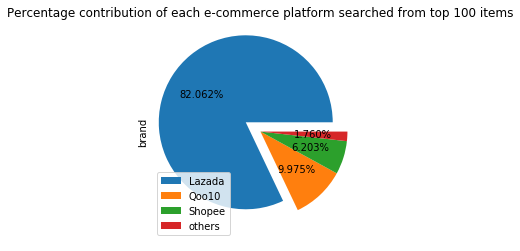

In [25]:
explode = [0.2] + [0 for _ in range(3)]
#plt.pie(data, labels=activities, colors=colors, startangle=90, autopct='%.1f%%')
plot_data = data.copy()
plot_data['brand'] = plot_data['brand'].apply(
    lambda x:x if (x == 'Lazada' or x == 'Qoo10' or x == 'Shopee'
                ) else 'others')

plot_data.brand.value_counts().plot(kind='pie', autopct='%.3f%%', explode=explode,labels=None)
plt.legend(plot_data.brand.unique(),loc=3)
plt.title("Percentage contribution of each e-commerce platform searched from top 100 items")
plt.show()

Insights:

- Lazada is the top platform which can be searched from iprice on electronics products (82%), followed by Qoo10 (6.2%) and Shopee (2.3%).

Generated Word Cloud from all item names crawled from Iprice.sg

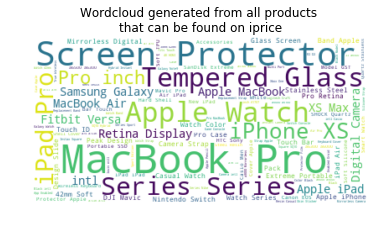

In [26]:
text = " ".join(name for name in data.name)
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud generated from all products \nthat can be found on iprice")
plt.show()

It looks like a lot of apple products can be found on iprice

Find average percentage of each e-commerce website contributed to the product

In [27]:
avg_per = data.groupby(['refer_name']).brand.value_counts(normalize=True)
avg_per

refer_name                                           brand           
Acer Spin 5 Touchscreen Laptop                       Lazada              0.666667
                                                     Qoo10               0.166667
                                                     Shopee              0.166667
Amazon Echo Dot (3rd Gen) Smart speaker with Alexa   Lazada              1.000000
Amazon Fire TV Stick 4K Streaming Player             Lazada              1.000000
Anki Vector Robot Sidekick                           Lazada              0.750000
                                                     Qoo10               0.250000
Apple HomePod - White                                Lazada              0.950000
                                                     Personal Digital    0.050000
Apple MacBook Air with Retina Display                Lazada              1.000000
Apple MacBook Pro with Touch Bar (15-inch)           Lazada              1.000000
Apple Watch Series 4        

In [28]:
avg_per.to_csv("average_distrubution_of_each_products_in_diff_platform.csv")

## After filtered out the false results returned by iprice

In [29]:
len(data[data['status']==1])

432

In [30]:
# How many of the result returned by Iprice are correct
sum(data['status']==1)/len(data)

0.36211232187761944

In [31]:
data_correct = data[data['status'] == 1]

In [32]:
avg_per_correct = data[data['status']==1].groupby(['refer_name']).brand.value_counts(normalize=True)


In [33]:
avg_per_correct

refer_name                                           brand           
Acer Spin 5 Touchscreen Laptop                       Lazada              0.555556
                                                     Qoo10               0.222222
                                                     Shopee              0.222222
Amazon Echo Dot (3rd Gen) Smart speaker with Alexa   Lazada              1.000000
Amazon Fire TV Stick 4K Streaming Player             Lazada              1.000000
Anki Vector Robot Sidekick                           Lazada              0.750000
                                                     Qoo10               0.250000
Apple HomePod - White                                Personal Digital    1.000000
Apple iPad (2018) Tablet                             Qoo10               1.000000
Apple iPad Pro                                       Apple               0.928571
                                                     Personal Digital    0.071429
Apple iPhone Xs and iPhone X

In [34]:
min_price_platform_each_product = data[data['status']==1].groupby(['refer_name'])['brand'].agg({'price':np.min})

/Users/kexinchong/Desktop/test_scrape/wh_flask/venv_flask/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [35]:
min_price_distr = min_price_platform_each_product['price'].value_counts()

In [36]:
min_price_distr

Lazada              31
Amazon               9
Apple                3
AliExpress           3
Harvey Norman        2
Qoo10                1
Personal Digital     1
Name: price, dtype: int64

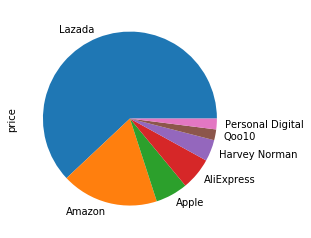

In [37]:
min_price_distr.plot(kind='pie')

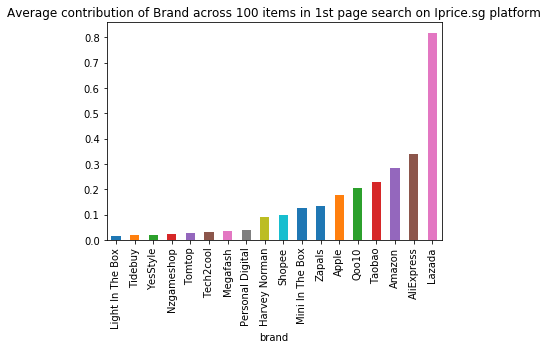

In [38]:
avg_per.groupby(["brand"]).mean().sort_values().plot(
    kind='bar', 
    title='Average contribution of Brand across 100 items in 1st page search on Iprice.sg platform')


Calculate jaro winkler distance and price_diff_ratio

In [39]:
for index,row in data.iterrows():
    data.loc[index,'dist_jw'] = L.jaro_winkler(row['name'], row['refer_name'])
    
data['price_diff_ratio'] = (data['price']-data['refer_price'])/data['refer_price']

Text(0.5, 1.0, 'Relationship between jaro-wrinkle distance and price_diff_ratio')

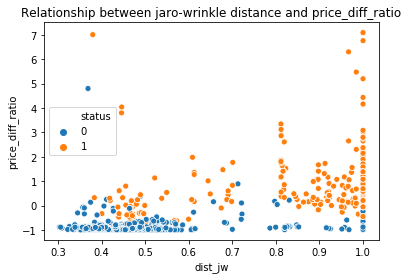

In [40]:
sns.scatterplot(data=data, x='dist_jw',y='price_diff_ratio', hue='status').set_title(
    "Relationship between jaro-wrinkle distance and price_diff_ratio")


Insights:
1. Observed that there exist a horizontal boundary around price_diff_ratio = -0.5 

Find the horizontal boundary by looping through values for price_diff_ratio ranging from minimum value of price_diff_ratio to 2

In [41]:
count_dict = {}
x = min(data['price_diff_ratio'])
while x<2:

    temp_data = data
    temp_data['guess'] = [1 if price>=x else 0 for price in data['price_diff_ratio'] ]
    correct = len(data[temp_data['status'] == temp_data['guess']])
    count_dict[x] = correct
    x = x+0.001

boundary_const = [max(count_dict, key=lambda x: count_dict[x])][0]

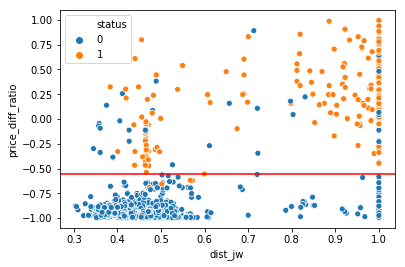

In [42]:
ax = sns.scatterplot(
    data=data[data['price_diff_ratio']<=1], 
    x='dist_jw',y='price_diff_ratio', hue='status')

plt.axhline(y=boundary_const, color='r', linestyle='-')
plt.show()

In [43]:
print("The horizontal line which seperate two classes the best is equal to {}".format(boundary_const))

The horizontal line which seperate two classes the best is equal to -0.5549135006937607


In [59]:
#Accuracy
count_dict[boundary_const]/len(data)

0.9413243922883487

## Train machine learning model

Firstly, we use logit model to fit our independent and dependent varaibles.

In [44]:
logit_model=sm.Logit(data['status'],data[["dist_jw","price_diff_ratio", "discount"]])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.212940
         Iterations 8
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.675      
Dependent Variable: status           AIC:              514.0747   
Date:               2018-12-23 11:15 BIC:              529.3274   
No. Observations:   1193             Log-Likelihood:   -254.04    
Df Model:           2                LL-Null:          -780.97    
Df Residuals:       1190             LLR p-value:      1.4377e-229
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------
dist_jw              1.0416   0.1726  6.0362 0.0000  0.7034 1.3798
price_diff_ratio     4.2037   0.2461 17.0816 0.0000  

Insights:
1. Discount variable is statistically insignificant, thus removing the variable and fit logit model as below.

In [45]:
logit_model=sm.Logit(data['status'],data[["dist_jw","price_diff_ratio"]])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.212954
         Iterations 8
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.675      
Dependent Variable: status           AIC:              512.1081   
Date:               2018-12-23 11:15 BIC:              522.2766   
No. Observations:   1193             Log-Likelihood:   -254.05    
Df Model:           1                LL-Null:          -780.97    
Df Residuals:       1191             LLR p-value:      3.5898e-231
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
-------------------------------------------------------------------
                  Coef.   Std.Err.     z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
dist_jw           1.0294    0.1591   6.4687  0.0000  0.7175  1.3413
price_diff_ratio  4.2228    0.2236  18.8876  0.00

All variables are statistically significant now, lets proceed to prediction of the model.

Split train and test data according to 80% and 20% respectively

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    data[["dist_jw","price_diff_ratio"]], data['status'], test_size=0.2, random_state=0)


Fit Logistic Regression model

In [47]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/kexinchong/Desktop/test_scrape/wh_flask/venv_flask/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.92


In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[140  10]
 [  9  80]]


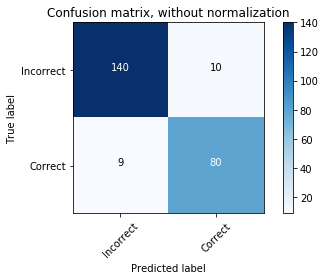

In [50]:
confusion_mat = confusion_matrix(y_test, y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_mat, classes=['Incorrect', 'Correct'],
                      title='Confusion matrix, without normalization')

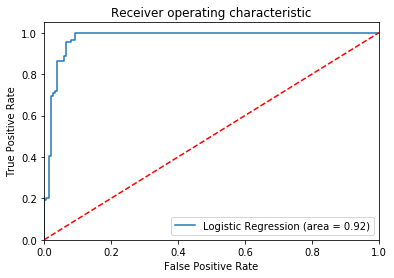

In [51]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Plot Decision Boundary of Logistic Regression

[(-5, 5), Text(0, 0.5, '$X_2$'), (-5, 5), Text(0.5, 0, '$X_1$'), None]

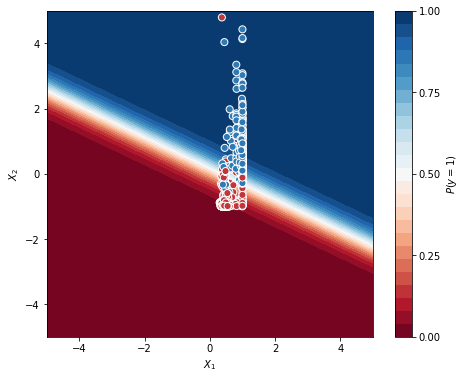

In [52]:
xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = logreg.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train.iloc[:,0], X_train.iloc[:,1], c=y_train, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$")


Train Support Vector Machine Classifier Model

In [53]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train) 

/Users/kexinchong/Desktop/test_scrape/wh_flask/venv_flask/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [54]:
y_pred = clf.predict(X_test)
print('Accuracy of SVM classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of SVM classifier on test set: 0.94


In [55]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train) 

/Users/kexinchong/Desktop/test_scrape/wh_flask/venv_flask/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [56]:
y_pred = clf.predict(X_test)
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of Random Forest classifier on test set: 0.96


                                            THE END